# 3. Regression

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Regression intro

- What is regression
- Supervised learning

### Linear regression

- Linear model
- Common approaches
  - Least squares
  - Bayesian linear regression

### California housing dataset

The California housing dataset includes

In [2]:
housing_data = fetch_california_housing(as_frame=True)

df = housing_data['frame']
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


The housing data comprises of 8 features:

- `MedInc`: Median income of the population in the block.
- `HouseAge`: Average age of houses in the block.
- `AveRooms`: Average number of rooms in a house in the block.
- `AveBedrms`: Average number of bedrooms in a house in the block.
- `Population`: Population of the block.
- `AveOccup`: The average number of people living in a house.
- `Latitude`: Latitudinal position.
- `Logitude`: Longitudinal position.
- `MedHouseVal`: The median value of houses in the block.
 
The target feature is `MedHouseVal`.

We shall now look at the datatypes for each feature.

In [3]:
print(df.dtypes)

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


Each of the features are numerical, as is the target feature which makes regression easier.

### Geographical data

As the data is geographical it is a good idea to visualise it as such.

Using the `Latitude` and `Longitude` features we can plot the data as a scatter plot. Using the `alpha` parameter we can get an idea of population density across California.

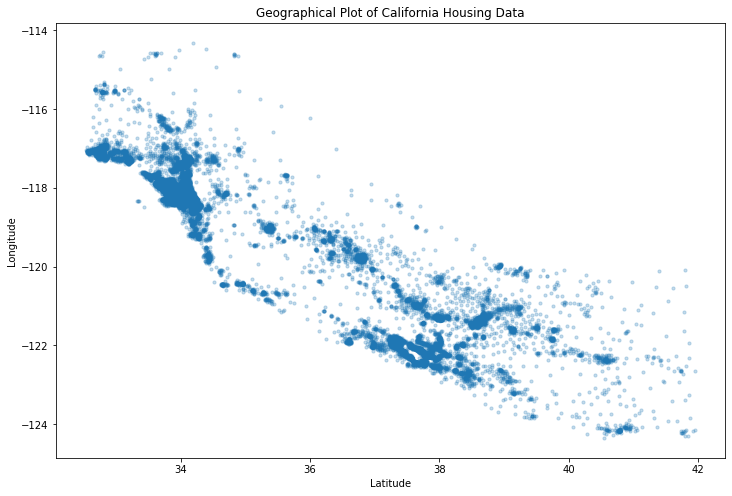

In [4]:
latitude = df['Latitude']
longitude = df['Longitude']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Geographical Plot of California Housing Data")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=10, alpha=0.25)
plt.show()

We can assume the whitespace in the lower left corner is due to no houses being located in the ocean. This means the high density points are along the coast, which may have a high correlation with house price.

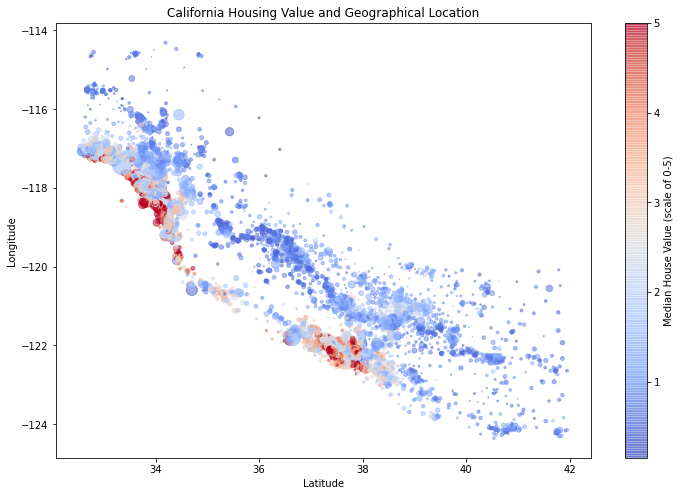

In [5]:
house_val = df['MedHouseVal']
population = df['Population']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("California Housing Value and Geographical Location")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=population/100, alpha=0.5, c=house_val, cmap='coolwarm')
plt.colorbar().set_label("Median House Value (scale of 0-5)")
plt.show()

From the scatter plot above we can see the more expensive (red) areas are closely packed, with the cheaper (blue) areas being far more scattered, as well as (generally) being further away from the coast. We can assume the more expensive areas relate to Los Angeles (north) and San Fransisco (south). We will need to ensure geographical data is encoded into the model as location evidetely has an impact on house price.

### Correlation and distribution

To get a quick look at the characteristics of the dataset we can use the `describe()` function.

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


From this we can see that some of the features have some large outlying values such as `AveRooms` and `AveOccup`, due to the max value being so much higher than the 75th percentile. We will have to handle this if we want to look at the histogram of the data as it may skew the results and not let us see the real distribution.

As we have already seen geographical data has a large impact on house value we will not explore its correlation with the other features any further. We will find the correlation between each of the remaining features.

In [7]:
non_geo = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
           'Population', 'AveOccup', 'MedHouseVal']

corr = df[non_geo].corr()
print(corr['MedHouseVal'].abs().sort_values(ascending=False))

MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveBedrms      0.046701
Population     0.024650
AveOccup       0.023737
Name: MedHouseVal, dtype: float64


We can see some inital results, such as income being highly correlated with house value but it will be easier to visualise as a correlation matrix.

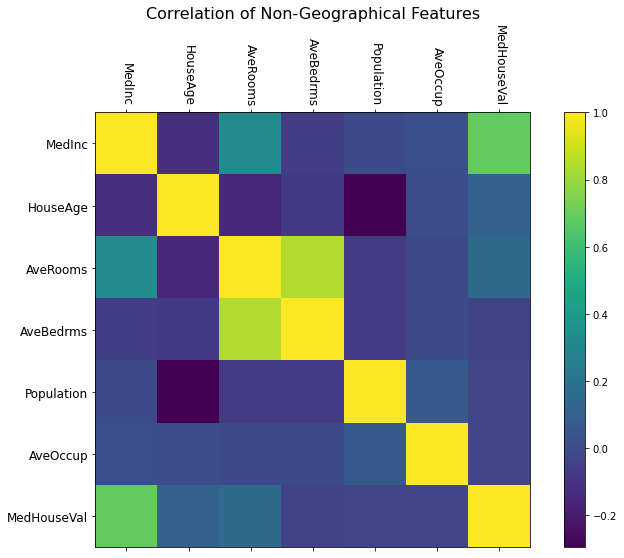

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
mat = ax.matshow(corr)
ax.set_xticks(range(len(non_geo)))
ax.set_yticks(range(len(non_geo)))
ax.set_xticklabels(non_geo, rotation=-90, fontsize=12)
ax.set_yticklabels(non_geo, fontsize=12)
plt.colorbar(mat, ax=ax)
plt.show()

We shall remove the highest values from some of the features with a long tail so we can get a better look at the disribution.

There are also some anomalies with the median house value and house age features. It seems that they have cut-offs of 5 and 50 repsectively and so there are a high number of them in the final bin on the histogram. This will have to be dealt with as to not skew the model.

In [9]:
df_nohigh = df.astype(float)
df_nohigh = df_nohigh.drop(df_nohigh[(df_nohigh['MedInc'] > 10) |
                                     (df_nohigh['HouseAge'] > 50) |
                                     (df_nohigh['AveRooms'] > 10) |
                                     (df_nohigh['AveBedrms'] > 2) |
                                     (df_nohigh['Population'] > 6000) |
                                     (df_nohigh['AveOccup'] > 8) |
                                     (df_nohigh['MedHouseVal'] > 4.7)].index)

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

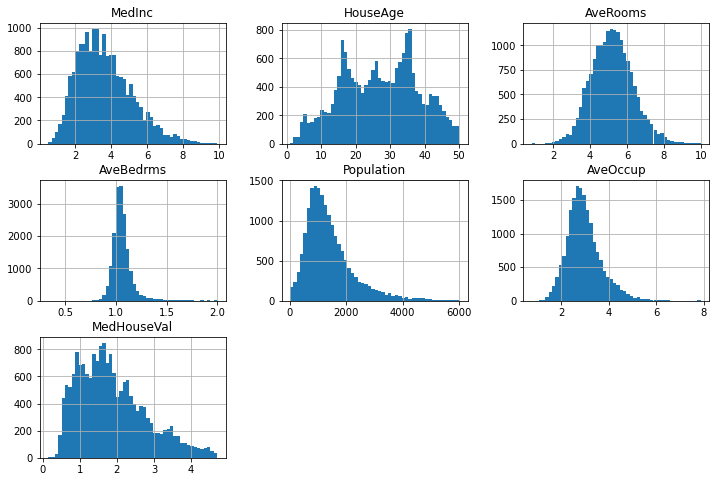

In [10]:
df_nohigh[non_geo].hist(bins=50, figsize=(12, 8))

It appears most features have a lognormal distribution - that is they rise sharply with a long right-hand tail. This is due to a a small number of blocks having abnormally large, high value homes.

Taking the log of these features should mean they are better fit by a normal distribution.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

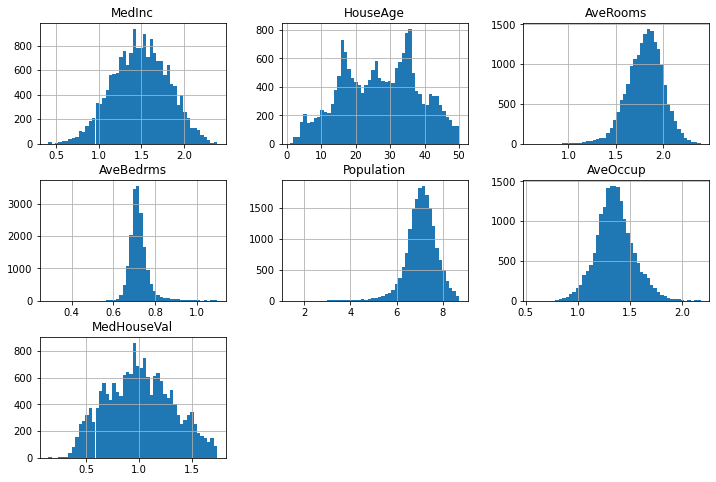

In [11]:
df_nohighnormal = df_nohigh.copy()
df_nohighnormal["MedInc"] = np.log1p(df_nohighnormal['MedInc'])
df_nohighnormal["AveRooms"] = np.log1p(df_nohighnormal['AveRooms'])
df_nohighnormal["AveBedrms"] = np.log1p(df_nohighnormal['AveBedrms'])
df_nohighnormal["Population"] = np.log1p(df_nohighnormal['Population'])
df_nohighnormal["AveOccup"] = np.log1p(df_nohighnormal['AveOccup'])
df_nohighnormal["MedHouseVal"] = np.log1p(df_nohighnormal['MedHouseVal'])

df_nohighnormal[non_geo].hist(bins=50, figsize=(12, 8))

We shall apply this transformation to our dataframe .

In [12]:
df_normal = df.copy()
df_normal["MedInc"] = np.log1p(df_normal['MedInc'])
df_normal["AveRooms"] = np.log1p(df_normal['AveRooms'])
df_normal["AveBedrms"] = np.log1p(df_normal['AveBedrms'])
df_normal["Population"] = np.log1p(df_normal['Population'])
df_normal["AveOccup"] = np.log1p(df_normal['AveOccup'])
df_normal["MedHouseVal"] = np.log1p(df_normal['MedHouseVal'])

### Missing data

Missing data will cause issues when it comes to training a model, so we will need to check for and deal with any missing data points.

In [13]:
df_normal.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

This seems to be a very clean dataset and does not have any missing values.

### Outliers

As with missing values, any outliers in the data could also cause our model to underperform.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

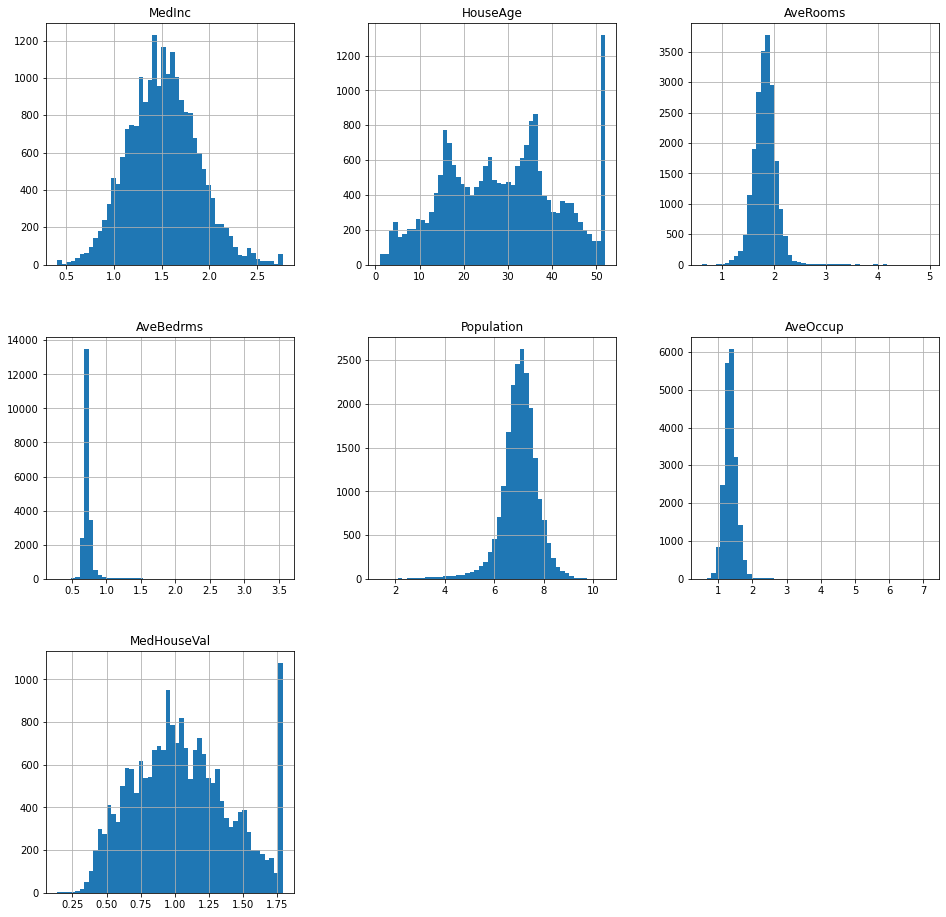

In [14]:
df_cut = df_normal.copy()
df_cut[non_geo].hist(bins=50, figsize=(16, 16))

It seems that the features `MedHouseVal` and `HouseAge` have been capped, this means there aren't any outliers but a large number of maximum values.

Had these values not been capped the data would have followed more of a lognormal distribution. That is the right-hand tail would have stretched out further slowly decreasing.

There is no way of recovering the lost data so instead we call cut off the cut-off. Later we shall scale the data so it should flatten out and be more normally distributed.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'MedHouseVal'}>]], dtype=object)

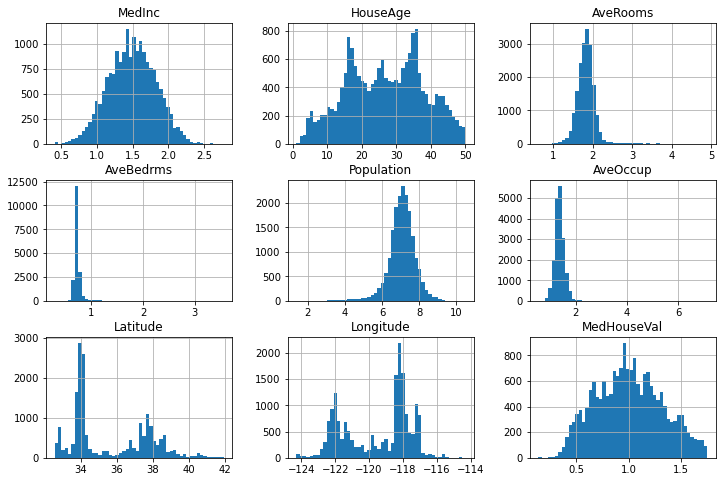

In [15]:
# df_nohigh = df[non_geo].astype(float)
df_cut = df_cut.drop(df_cut[(df_cut['HouseAge'] > 50) |
                            (df_cut['MedHouseVal'] > 1.75)].index)

df_cut.hist(bins=50, figsize=(12, 8))

### Feature engineering

It can be benificial to create additional features.

In [16]:
print(df_cut.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


In [17]:
extra_df = df_cut.copy()

extra_df['AveBedrmsPerRoom'] = extra_df['AveBedrms'] / extra_df['AveRooms']
extra_df['AveBedrmsPerOccup'] = extra_df['AveBedrms'] / extra_df['AveOccup']
extra_df['AveAddRooms'] = extra_df['AveRooms'] - extra_df['AveBedrms']
extra_df['EstHouses'] = extra_df['Population'] / extra_df['AveOccup']

new_features = ['MedHouseVal', 'AveBedrmsPerRoom', 'AveBedrmsPerOccup',
                'AveAddRooms', 'EstHouses']

new_features_corr = extra_df.corr()
new_features_corr['MedHouseVal'].abs().sort_values(ascending=False)

# fig, ax = plt.subplots(figsize=(12, 8))
# ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
# mat = ax.matshow(new_features_corr)
# ax.set_xticks(range(len(new_features)))
# ax.set_yticks(range(len(new_features)))
# ax.set_xticklabels(new_features, rotation=-90, fontsize=12)
# ax.set_yticklabels(new_features, fontsize=12)
# plt.colorbar(mat, ax=ax)
# plt.show()

MedHouseVal          1.000000
MedInc               0.660354
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
AveRooms             0.167882
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
Longitude            0.009847
HouseAge             0.002083
Name: MedHouseVal, dtype: float64

It seems the new bedrooms per room and additional rooms features are both better features than the individual bedroom and room features. We shall keep these and remove the original features. Estimated houses also seems to have added some good information so we shall keep it in the feature set.

The average bedrooms per person has not added any more information to the dataset so we shall remove this.

As for the geographical data we shall encode this later on.

#### Creating geographical features

As mentioned above, the geographical features `Latitude` and `Longitude` can be transformed into a single feature to represent distance to the closest city (LA and San Fransisco). The longitude and latitude seem to line up with real life positions so we shall get the positions of LA and San Fransisco from Google maps.

In [18]:
# LA location as north-westerly peak
la_lat, la_lon = 34.0522, -118.2437
# SF location as south-easterly peak
sf_lat, sf_lon = 37.7749, -122.4194

extra_df['DistToLA'] = np.sqrt((extra_df['Latitude'] - la_lat)**2 +
                               (extra_df['Longitude'] - la_lon)**2)
extra_df['DistToSF'] = np.sqrt((extra_df['Latitude'] - sf_lat)**2 +
                               (extra_df['Longitude'] - sf_lon)**2)

extra_df['DistToCity'] = extra_df[['DistToLA', 'DistToSF']].min(axis=1)

Now lets look at the correlation of this new feature with median house price.

In [19]:
city_corr = extra_df.corr()
city_corr['MedHouseVal'].abs().sort_values(ascending=False)

MedHouseVal          1.000000
MedInc               0.660354
DistToCity           0.494316
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
DistToLA             0.169382
AveRooms             0.167882
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
Longitude            0.009847
HouseAge             0.002083
DistToSF             0.002023
Name: MedHouseVal, dtype: float64

This has created another great feature. As the distance to city feature is so much stronger than any other geographical feature we shall use this and drop the others.

We shall also check the distribution of this new feature.

<AxesSubplot:>

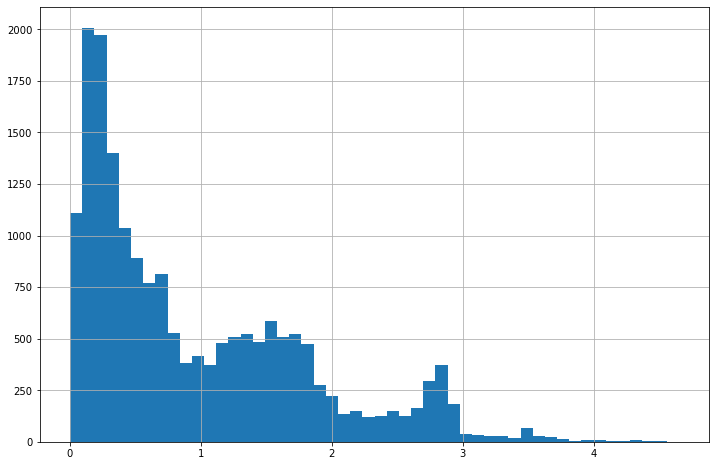

In [20]:
extra_df['DistToCity'].hist(bins=50, figsize=(12, 8))

The distribution doesnt seem clear which is likely down to the very centre of the city not being the most expensive and decreasing as they go out.

To add some more accuracy we can add some more known expensive areas around California. A quick google search lists the following cities as the top 10 most expensive areas as:

- Atherton (37.4613° N 122.1997° W)
- Santa Monica (34.0195° N, 118.4912° W)
- Beverly Hills (34.0736° N, 118.4004° W)
- Palo Alto (37.4419° N, 122.1430° W)
- Los Altos (94022) (37.3852° N, 122.1141°W)
- Ross (37.9624° N, 122.5550° W)
- Portola Valley (37.3841° N, 122.2352° W)
- Los Altos (94024) (37.3478° N, 122.1008° W)
- Newport Beach (92661) (33.6189° N, 117.9298° W)
- Newport Beach (92662) (33.6061° N, 117.8912° W)

I shall also add a point for San Diego at 32.7157° N, 117.1611° W.

We shall calculate the distances for each bloc to these areas and add a new feature to represent the miniumum of these.

In [21]:
town_coords = np.array([[37.4613, -122.1997],
                        [34.0195, -118.4912],
                        [34.0736, -118.4004],
                        [37.4419, -122.1430],
                        [37.3852, -122.1141],
                        [37.9624, -122.5550],
                        [37.3841, -122.2352],
                        [37.3478, -122.1008],
                        [33.6189, -117.9298],
                        [33.6061, -117.8912],
                        [32.7157, -117.1611]])

coords = np.asarray(extra_df[['Latitude', 'Longitude']])

town_dists = np.asarray([np.sqrt((coords[:, 0] - town_coord[0])**2 + 
                                 (coords[:, 1] - town_coord[1])**2) 
                         for town_coord in town_coords])

dist_to_town = np.min(town_dists, axis=0)

We can now add the new feature and compare it to the original distance to city.

<AxesSubplot:>

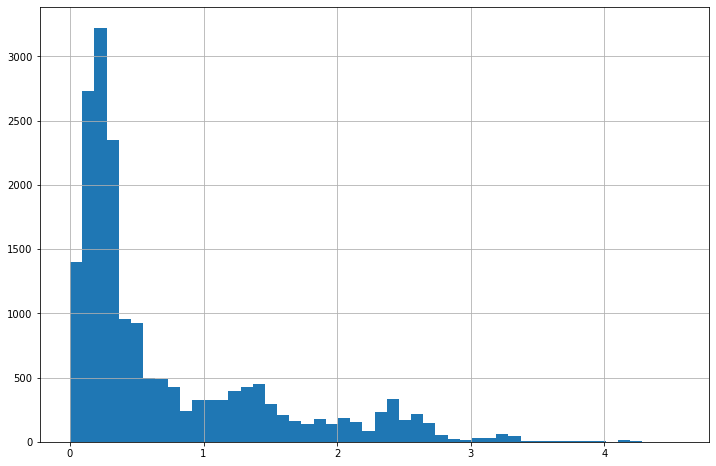

In [22]:
extra_df['DistToTown'] = dist_to_town
extra_df['DistToTown'].hist(bins=50, figsize=(12, 8))

In [23]:
city_corr = extra_df.corr()
city_corr['MedHouseVal'].abs().sort_values(ascending=False)

MedHouseVal          1.000000
MedInc               0.660354
DistToTown           0.543483
DistToCity           0.494316
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
DistToLA             0.169382
AveRooms             0.167882
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
Longitude            0.009847
HouseAge             0.002083
DistToSF             0.002023
Name: MedHouseVal, dtype: float64

As I hoped this had improved the correlation further.

We can now transform this to a normal distribution.

<AxesSubplot:>

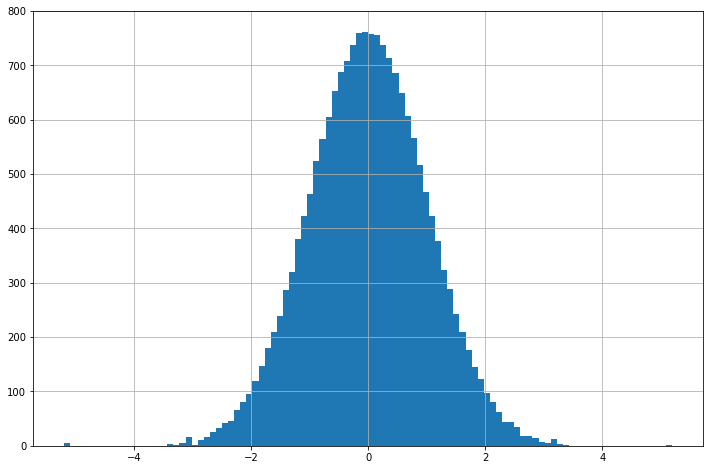

In [24]:
qt = QuantileTransformer(output_distribution="normal")
normal_dist_to_town = qt.fit_transform(dist_to_town.reshape(-1, 1))

extra_df['DistToTown'] = normal_dist_to_town
extra_df['DistToTown'].hist(bins=100, figsize=(12, 8))

### Categorical features

Categorical features in the data usually need to be encoded into numerical features for a machine learning algorithm to learn from them, especially with a regression model.

With this dataset there are only numerical features and all are of float type, so we can leave them as they are.

### Feature scaling

Now we have created all the features we shall used we shall apply scaling so features are centered with 0 mean.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'AveBedrms'}>],
       [<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerOccup'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>],
       [<AxesSubplot:title={'center':'EstHouses'}>,
        <AxesSubplot:title={'center':'DistToLA'}>,
        <AxesSubplot:title={'center':'DistToSF'}>,
        <AxesSubplot:title={'center':'DistToCity'}>],
       [<AxesSubplot:title={'center':'DistToTown'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

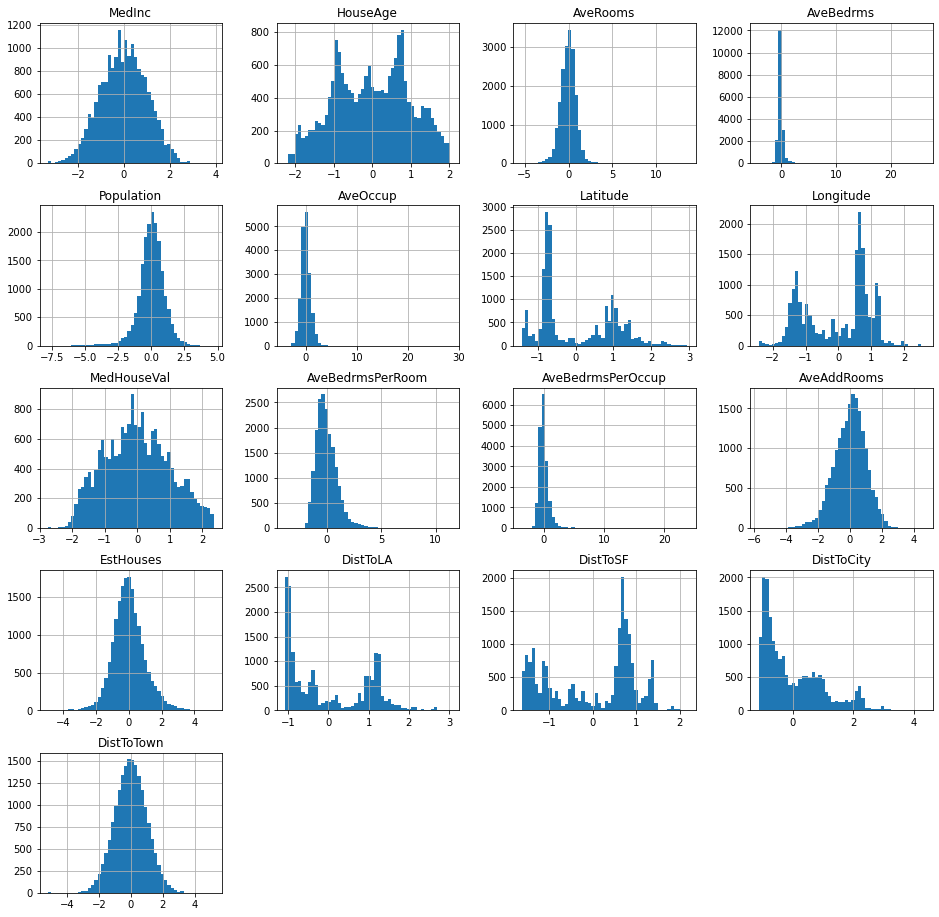

In [25]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(extra_df),
                         columns=extra_df.columns)

df_scaled.hist(figsize=(16, 16), bins=50)

Another scaling technique we can try is sklearns quantile transformer. It attempts to fit the data to a normal distribution which should help us when it comes to picking our Bayesian prior distribution.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'AveBedrms'}>],
       [<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerOccup'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>],
       [<AxesSubplot:title={'center':'EstHouses'}>,
        <AxesSubplot:title={'center':'DistToLA'}>,
        <AxesSubplot:title={'center':'DistToSF'}>,
        <AxesSubplot:title={'center':'DistToCity'}>],
       [<AxesSubplot:title={'center':'DistToTown'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

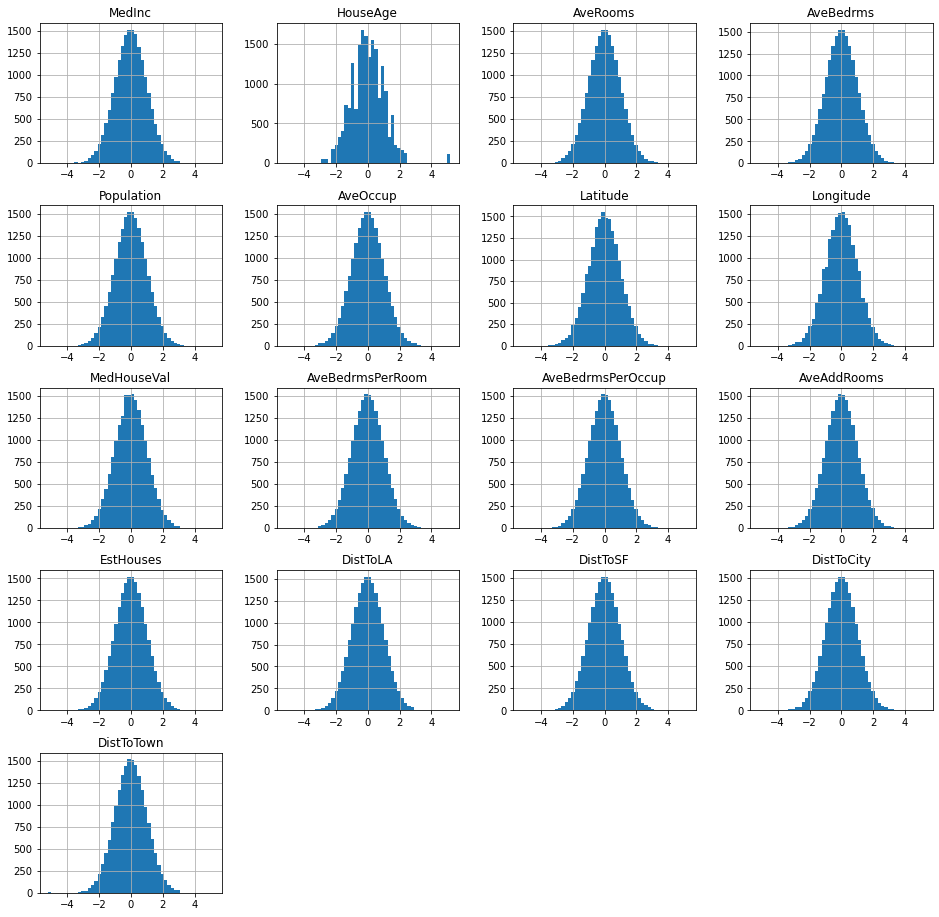

In [26]:
qt = QuantileTransformer(output_distribution="normal")
normal_transformed_df = pd.DataFrame(qt.fit_transform(extra_df),
                                     columns=extra_df.columns)

normal_transformed_df.hist(figsize=(16, 16), bins=50)

This has worked well and we can clearly see that the new transformation has normally distributed most of the features.

One notable outlier is the house age feature. My hypothesis is that house age cannot be normally distributed as both old and new houses can be expensive. It does not seem to be a feature that correlates well with house price so we may drop it later on when it comes to selecting the final features.

### Feature Selection

As discussed in part one reducing the number of dimensions can also be benificial for both the training time and generalisation of the model. This can be done by removing unnescessary features, but also by combining similar features.

In [27]:
corr = normal_transformed_df.corr()
print(corr["MedHouseVal"].abs().sort_values(ascending=False))

MedHouseVal          1.000000
MedInc               0.655037
DistToTown           0.531992
DistToCity           0.418629
AveBedrmsPerRoom     0.311844
AveAddRooms          0.280193
EstHouses            0.234973
AveOccup             0.214394
AveRooms             0.208717
DistToLA             0.193778
Latitude             0.193461
AveBedrms            0.142386
AveBedrmsPerOccup    0.118035
DistToSF             0.096097
Longitude            0.056947
Population           0.055694
HouseAge             0.002960
Name: MedHouseVal, dtype: float64


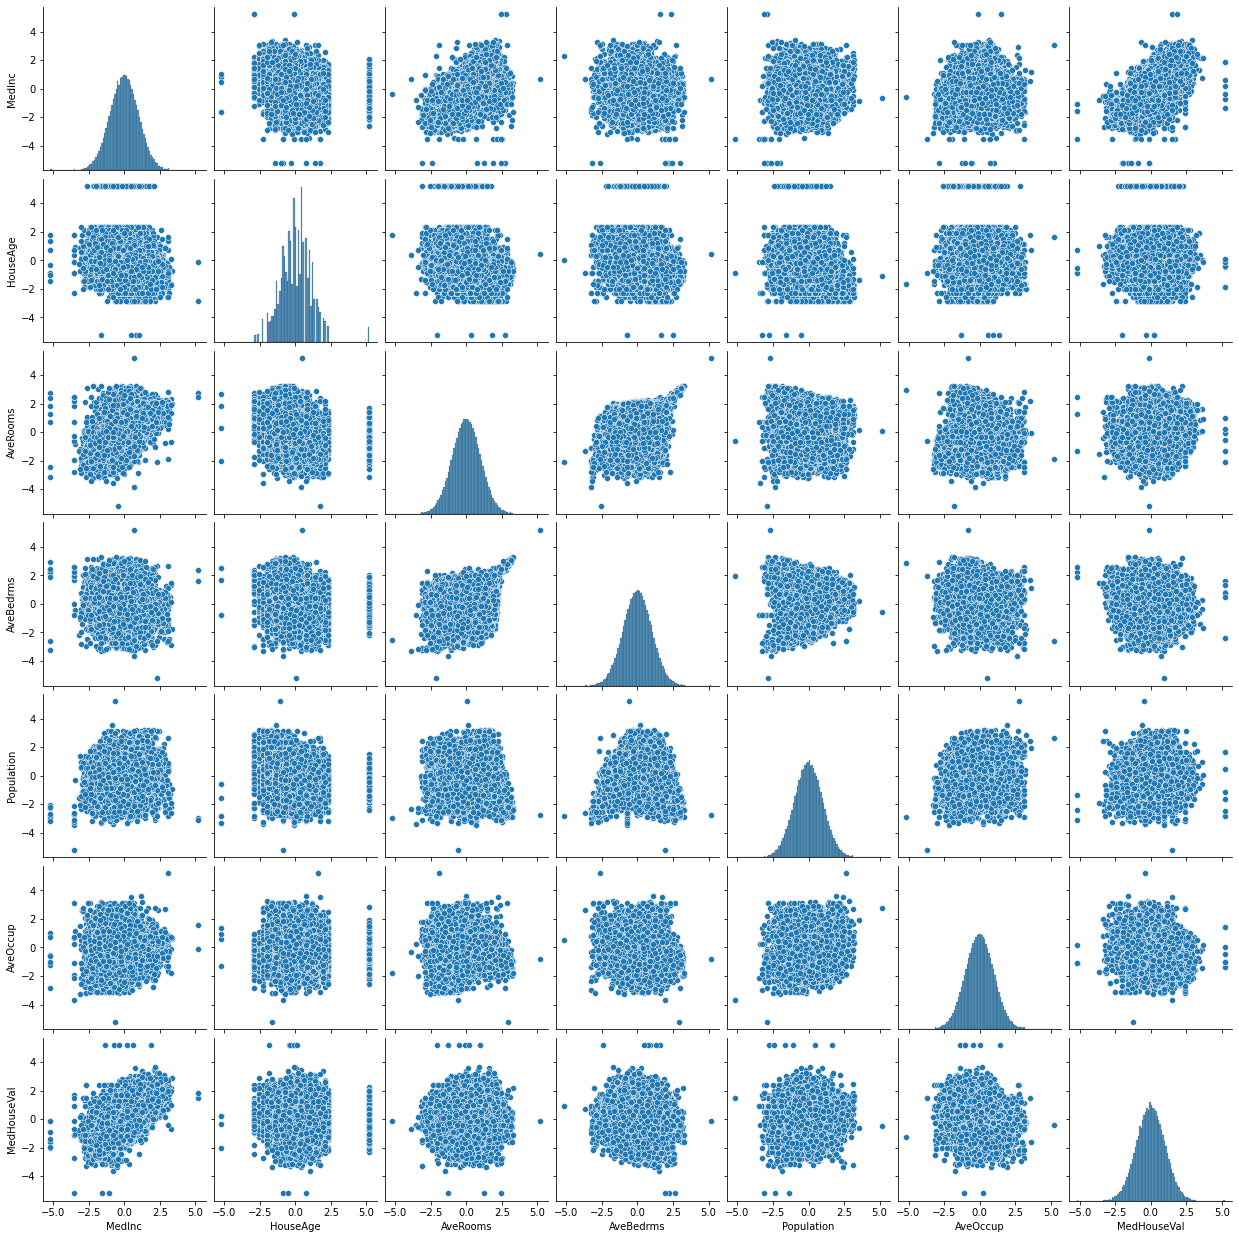

In [28]:
sns.pairplot(normal_transformed_df[non_geo])

We shall remove the bedroom and room features as the new bedrooms per room feature has better correlation.

As discussed earlier we shall remove all of the geographical features apart from `DistToTown`.

We shall also remove the bedrooms per person feature we created as it does not provide any more useful information.

The population and house age features also seem to have little correlation to house price also so we shall also remove those.

In [29]:
normal_transformed_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'AveBedrmsPerRoom',
       'AveBedrmsPerOccup', 'AveAddRooms', 'EstHouses', 'DistToLA', 'DistToSF',
       'DistToCity', 'DistToTown'],
      dtype='object')

In [30]:
features_to_remove = ['AveRooms', 'AveBedrms', 'Latitude', 'Longitude',
                      'DistToLA', 'DistToSF', 'DistToCity',
                      'AveBedrmsPerOccup', 'Population', 'HouseAge']

data = normal_transformed_df.drop(features_to_remove, axis=1, inplace=False)
data.head()

,MedInc,AveOccup,MedHouseVal,AveBedrmsPerRoom,AveAddRooms,EstHouses,DistToTown
0,2.427473,-0.526872,2.486522,-1.582225,1.580483,-0.990437,0.000485
1,2.417248,-1.315488,1.544208,-1.453747,1.169379,1.810635,0.036998
2,-1.089794,-1.452319,0.540157,0.977285,-0.937798,1.397035,-0.061046
3,-1.046576,-0.377947,-0.382574,0.792621,-0.881434,-0.231418,-0.074511
4,-1.179374,-0.882843,-0.156044,0.019754,0.044681,0.630910,-0.061046


In [31]:
data.corr()['MedHouseVal'].abs().sort_values(ascending=False)

MedHouseVal         1.000000
MedInc              0.655037
DistToTown          0.531992
AveBedrmsPerRoom    0.311844
AveAddRooms         0.280193
EstHouses           0.234973
AveOccup            0.214394
Name: MedHouseVal, dtype: float64

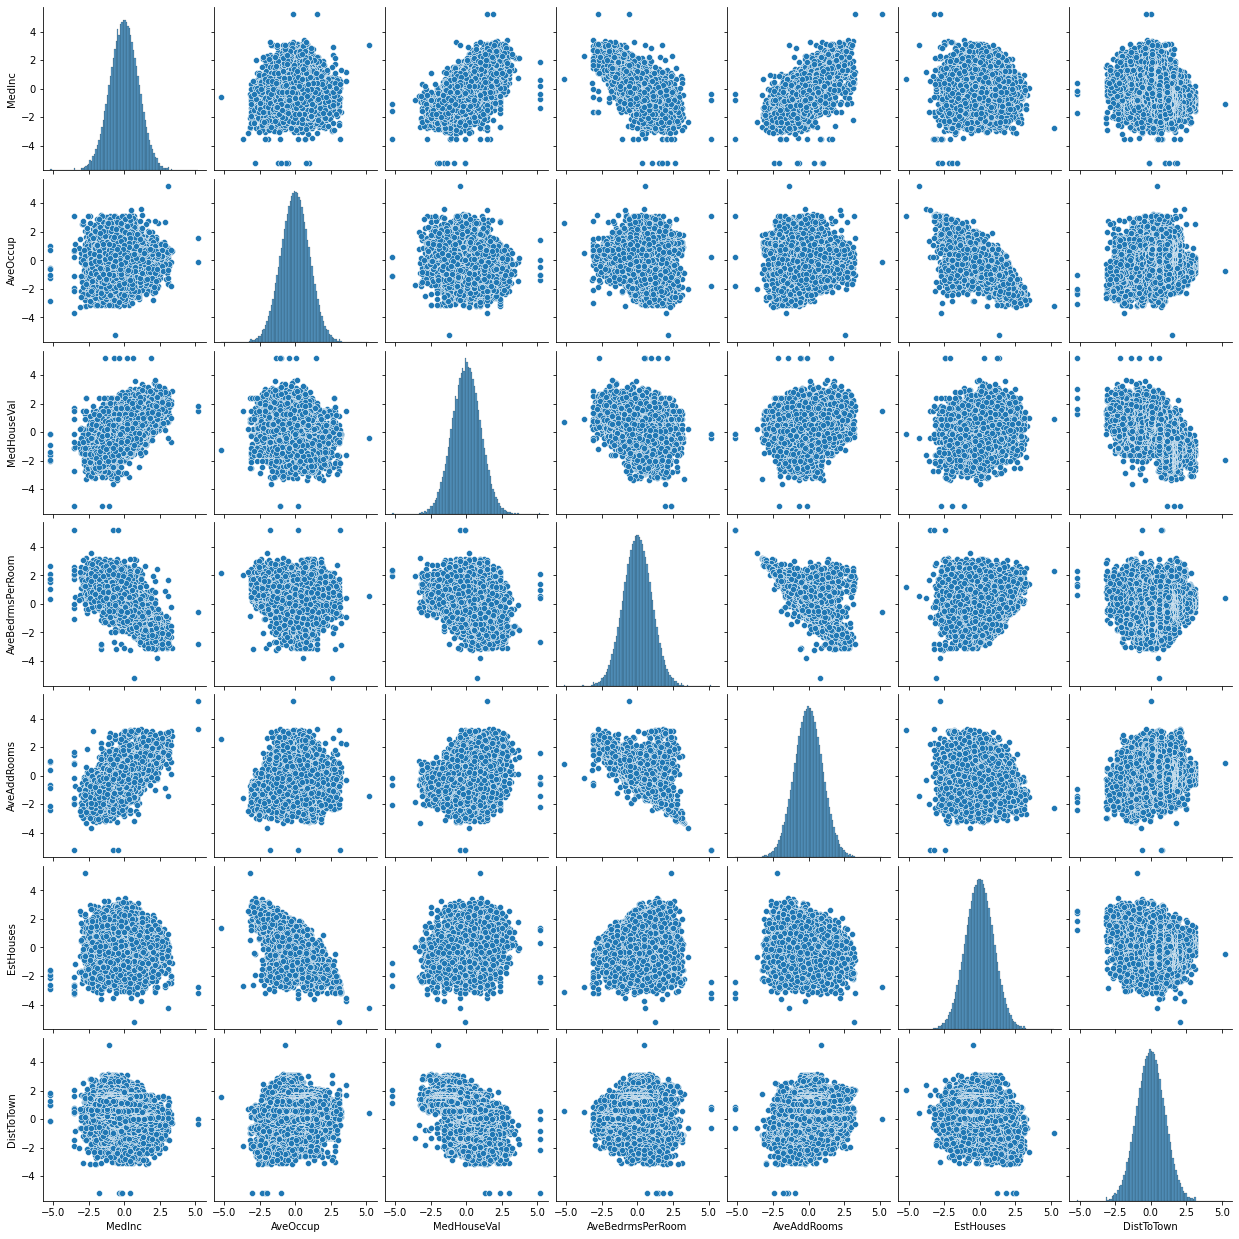

In [32]:
sns.pairplot(data)

We now have the most correlating features, whilst removing a lot of the shared information across features.

There are some obvious strong correlations between bedrooms per room and additional rooms, but there are some more useful correlations between house value and distance to closest expensive town, as well as median income which should provide good results for regression.

We have also reduced the dimensionality of the data which should aid both model training ease and generalisation.

### Remove some of the above plots
### Make some of the plots nicer for report

It appears most features have a lognormal distribution - that is they rise sharply with a long right-hand tail. This is due to a a small number of blocks having abnormally large, high value homes.

Taking the log of these features should mean they are better fit by a normal distribution.
### Notes on sampling

- In group bias
- Ground truth
- Prior belief
- Sampling bias
- Selection bias
- Bias variance trade-off

## Bayesian Linear Regression

#### Bayes Theorem

- Bayes theorem
- Bayes rule
- Bayesian statistics

#### Bayesian linear regression

- What is bayesian linear regression

#### MCMC

- Markov chain
- Markov property
- MCMC
- Metropolis Hastings

#### Performance measure

Regression does not provide a precise estimate for classes like classification, instead it trys to fit a line of best fit. To measure the performance of different regression models on the data we will use various measures based on the distances of each point to this line. 

We will mostly be interested in maximising the R2 score for the model, as this is the score method used by the Scikit-learn regression models we will be comparing it to. R2 is the coefficient of determination, it describes how well the model fits to the data. A model with a R2 score of 1.0 represents all of the data perfectly and so we shall by trying to increase the R2 score of the model on a training set towards that.

Additionaly it will be useful to measure both mean squared error (MSE) and root mean squared error (RMSE). These two measures take the mean of the squared distances of all the points to the regression line, with RMSE taking the square root of that as to give worse weighting to models with outlying data.

This 3 metrics will be analysed often so a function to do so will be useful.

In [33]:
# output R2, MSE and RMSE of regressor
def reg_metrics(reg, reg_name, X, y):
    reg_preds = reg.predict(X)
    reg_r2 = r2_score(y, reg_preds)
    reg_mse = mean_squared_error(y, reg_preds)
    reg_rmse = mean_squared_error(y, reg_preds, squared=False)
    print(f"{reg_name} regression R2:   {reg_r2:.4f}")
    print(f"{reg_name} regression MSE:  {reg_mse:.4f}")
    print(f"{reg_name} regression RMSE: {reg_rmse:.4f}")

#### Data processing pipeline

For convenience I have created a module which provides the above data pipeline. The function has an optional parameter to specify the test size, with the deafult being 20%.

It will return the california housing data as 4 Pandas DataFrames:

- X_train - training data
- X_test - testing data
- y_train - real house prices for training
- y_test - real house prices for testing

In [34]:
import california_data_pipeline as cp
import importlib
importlib.reload(cp)

X_train, X_test, y_train, y_test = cp.load_train_test()

In [35]:
X_train.describe()

,MedInc,AveOccup,AveBedrmsPerRoom,AveAddRooms,EstHouses,DistToTown
count,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000
mean,0.000371,-0.004979,-0.002462,0.005138,0.003706,0.003946
std,1.006309,0.998226,1.001051,1.000312,1.002711,1.002444
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.676720,-0.670557,-0.679977,-0.672923,-0.670373,-0.670163
50%,0.001716,-0.004677,-0.006352,0.003248,0.001016,0.002993
75%,0.674471,0.668904,0.671255,0.676388,0.679753,0.679072
max,5.199338,3.594287,5.199338,5.199338,5.199338,5.199338


#### Standard linear regression

To get an idea of how a regression model should perform on the data it is a good idea to fit a standard linear regression model and gather some initial metrics.

In [36]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
reg_metrics(linreg, "linear", X_test, y_test)

linear regression R2:   0.6165
linear regression MSE:  0.3721
linear regression RMSE: 0.6100


It appears standard linear regression is able to fit to the data quite well, with quite a high R2 score. MSE is also relatively low and RMSE is not too high. 

This will be a good comparison point to ensure our Bayesian model is performing accurately.

#### Prior beliefs about data

As shown through the earlier data analysis the distribution for all features in our training set is normal. The distribution of the 

### Bayesian linear regression

- describe the model
- ...

#### Scikit-learn wrapper class

For ease of use and integration with Scikit-learn functionality I have created a class for my Bayesian linear regression model. It extends the `sklearn.base.BaseEstimator` and `sklearn.base.RegressorMixin` classes and implements `fit()`, `predict()` and `score()` methods. With this we can use the bayesian linear regression object like any other Scikit-learn regressor.

- `fit()` - Takes in the training data and labels then creates a linear equation based on the column names of the input data frame. It then sets the prior distributions to normal and and begins sampling with MCMC. The samples are then available through the trace attribute. Note: Scikit-learn will convert Pandas DataFrames to Numpy arrays and drop the column names so when using the `BayesianLinearRegression` class with Scikit-Learn functionality such as ensemble methods optinal parameters to pass in feature and target names are provides so the fit function can still create a linear formula for the GLM module.
- `predict()` - Takes in a set of features and returns the most likely predictions. Bayesian regression produces a distribution of coefficients for each variable so it does not just predict one value, but for comparisons with non-probabilistic models and use with ensemble methods `predict()` will take the mean of the samples as the coefficients for each variable and make a prediction with that linear model.
- `score()` - Takes a test set and the real values for that set. It then uses `predict()` to make predictions for the test set and calculate the R2 score between the real and predicted values. This method will also calculate the `mse` and `rmse` attributes in the object.

We shall create an instance of `BayesianLinearRegression`:

In [37]:
import bayesian_linear_regressor as br
import importlib
importlib.reload(br)

bayesianreg = br.BayesianLinearRegression()

Call `fit()` with the training features `X` and real values `y` with the model formula create and sample from the model.

Additional parameters `n_samples`, `n_tune` and `n_cores` are available.

In [38]:
bayesianreg.fit(X_train, y_train, n_samples=3000, n_tune=2000, n_cores=8)

/home/kai/Git/ml-analysis/notebooks/bayesian_linear_regressor.py:61: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = pm.sample(draws=n_samples, tune=n_tune,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sd, DistToTown, EstHouses, AveAddRooms, AveBedrmsPerRoom, AveOccup, MedInc, Intercept]


Sampling 8 chains for 2_000 tune and 3_000 draw iterations (16_000 + 24_000 draws total) took 31 seconds.


BayesianLinearRegression()

#### Model analysis

Call `predict` with test features `X` to return predicted values from the most likely model.

In [39]:
preds = bayesianreg.predict(X_test)

This will also instanciate the objects mean coefficients attribute:`bayesianreg.mean_coeffs_`.

In [40]:
print(bayesianreg.mean_coeffs)

[ 6.15743532e-04  6.24265664e-01 -1.44410077e-01  1.03622861e-01
  3.65505956e-02  4.41584882e-02 -3.97624432e-01 -5.02622555e-01
  6.04952272e-01]


Now the model has been 'trained' we can use it to make predictions for the test set and calculate the performance measures discussed earlier.

In [41]:
reg_metrics(bayesianreg, "bayesian linear", X_test, y_test)
# r2 = bayesianreg.score(X_test, y_test)
# print(f"Bayesian linear regression R2: {r2}")
# print(f"Bayesian linear regression MSE:  {bayesianreg.mse_}")
# print(f"Bayesian linear regression RMSE: {bayesianreg.rmse_}")

bayesian linear regression R2:   0.6165
bayesian linear regression MSE:  0.3721
bayesian linear regression RMSE: 0.6100


<ipython-input-42-b271f1066d72>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(bayesianreg.trace)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'MedInc'}>],
       [<AxesSubplot:title={'center':'AveOccup'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>],
       [<AxesSubplot:title={'center':'AveAddRooms'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>],
       [<AxesSubplot:title={'center':'EstHouses'}>,
        <AxesSubplot:title={'center':'EstHouses'}>],
       [<AxesSubplot:title={'center':'DistToTown'}>,
        <AxesSubplot:title={'center':'DistToTown'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

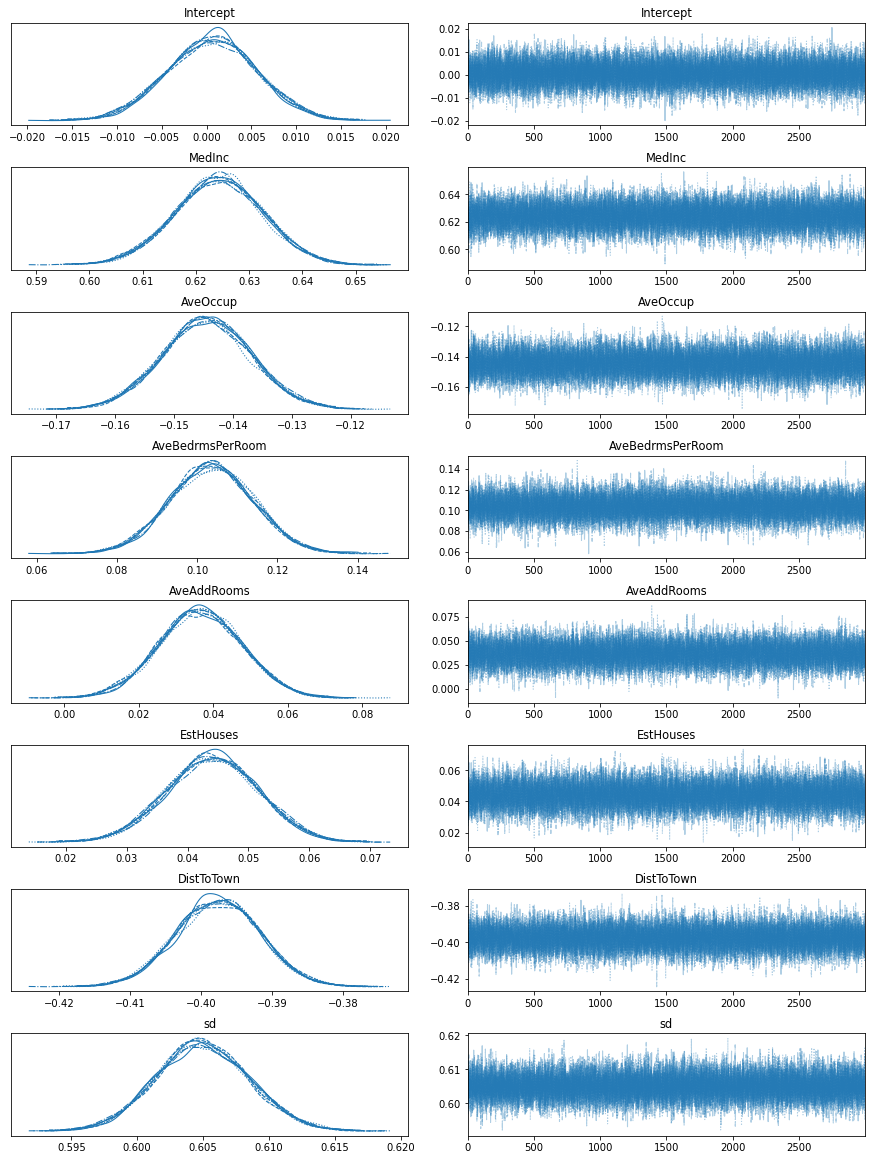

In [42]:
pm.traceplot(bayesianreg.trace)

---

- trace plots
- plot posterior
- waic / oob
- plot regression line(s) for house val vs. med income and dist to town
- discuss results

---

#### Further Bayesian linear regression optimisations

This model uses ridge regression, which is a good way to normalise the model and force better generalisation. Another method I would try is lasso regression which works in a similar way but **???***. Elasti-net regression trys to implement both methodologies and seems like it should perform well.

### Bayesian regression conclusion

- Concluding points on things learnt from dataset.
- Concluding points of Bayesian regression performance (vs normal).
- Bayesian stats and modelling benefits in general.